# Lab 1: Sentiment Analysis with Logistic Regression using Keras

## Introduction

In this lab session we will implement a Logistic Regression model for __sentence classification__ using Keras. Given a sentence our model will predict if it is a positive or negative piece of texts. The dataset we are going to use ranges the polarity annotation from 0 to 5, where 0 denotes extremely negative sentiment,  and 5  is the most positive.

Nevertheless, for this lab we'll  simplify the task, and we will translate the 5-way classification task into 2-way classification task (0 $\rightarrow$ _negative,_ ;1 $\rightarrow$ positive),


All in all, the main __objectives__ of this first laboratory are the following:
- Learn how to build, train and evaluate a Logistic Regression Model in Keras
- Preprocessing of the input (e.g. one-hot-encoding)
- Explore hyperparameters like:
  - Learning Rates
  - number of epochs
- Plot learning curves for model selection



## 1. Loading the data

Let's load the Stanford Sentiment Treebank.  The data can be originaly downloaded from here: [the train/dev/test Stanford Sentiment Treebank distribution](http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip).

In order to load the data, you will need to mount your Drive folder first and give the access to the Notebook. This will require one-step authentication. Please when you run the cell below follow the instructions.

Once you mount everything, make sure ```sst_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/utils/sst_custom_loader'``` is the correct path for the custom data loader script. We will use the load_data function of the datasets library. In this case, we will use a custom data loader to download the data and process it for our lab, but you can download tons of data from https://huggingface.co/datasets directly.


Please run the following cells to load the data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# install libraries
!pip install tensorflow
!pip install datasets==2.17.1
# import load_dataset from dataset
from datasets import load_dataset
# set seed for replicability of results
import numpy as np
import pandas as pd
import tensorflow as tf
tf.keras.utils.set_random_seed(2)

In [3]:
print(tf.__version__)

2.19.0


In [4]:
# custom data loader path ALDATU
home = '/content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/'
sst_home = home + 'utils/sst_custom_loader.py'
# load data with load_dataset and our custom data loader script
data = load_dataset(sst_home)
training_set = pd.DataFrame(data['train'])
dev_set = pd.DataFrame(data['validation'])
test_set = pd.DataFrame(data['test'])

print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

/usr/local/lib/python3.12/dist-packages/datasets/load.py:923: FutureWarning: The repository for sst_custom_loader contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/utils/sst_custom_loader.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Training size: 6920
Dev size: 872
Test size: 1821


## 2. Examining the data

In [5]:
pd.set_option('max_colwidth', 1000)
# Print a sample of negative text chunks
training_set[training_set.label == 0].head(10)

,label,text
22,0,This is n't a new idea .
34,0,... a sour little movie at its core ; an exploration of the emptiness that underlay the relentless gaiety of the 1920 's ... The film 's ending has a `` What was it all for ? ''
37,0,Made me unintentionally famous -- as the queasy-stomached critic who staggered from the theater and blacked out in the lobby .
52,0,The modern-day royals have nothing on these guys when it comes to scandals .
53,0,It 's only in fairy tales that princesses that are married for political reason live happily ever after .
59,0,An absurdist spider web .
76,0,"By no means a slam-dunk and sure to ultimately disappoint the action fans who will be moved to the edge of their seats by the dynamic first act , it still comes off as a touching , transcendent love story ."
110,0,It 's not a great monster movie .
144,0,"Too often , Son of the Bride becomes an exercise in trying to predict when a preordained `` big moment '' will occur and not `` if . ''"
148,0,A party-hearty teen flick that scalds like acid .


In [6]:
# Print a sample of positive text chunks
training_set[training_set.label == 1].head(10)

,label,text
0,1,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."
1,1,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .
2,1,"Singer\/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece ."
3,1,Yet the act is still charming here .
4,1,"Whether or not you 're enlightened by any of Derrida 's lectures on `` the other '' and `` the self , '' Derrida is an undeniably fascinating and playful fellow ."
5,1,Just the labour involved in creating the layered richness of the imagery in this chiaroscuro of madness and light is astonishing .
6,1,Part of the charm of Satin Rouge is that it avoids the obvious with humour and lightness .
7,1,a screenplay more ingeniously constructed than `` Memento ''
8,1,`` Extreme Ops '' exceeds expectations .
9,1,"Good fun , good action , good acting , good dialogue , good pace , good cinematography ."


## 3. Preprocessing the data
Once data is loaded the next step is to preprocess it to obtain the vectorized form (i.e. the process of transforming text into numeric tensors), which basically consist of:

- Tokenization, tipically segment the text into words. (Alternatively, we could segment text into characters, or extract n-grams of words or characters.)
- Definition of the dictionary index and vocabulary size (in this case we set to 1000 most frequent words)
- Transform each word into a vector.


There are multiple ways to vectorize tokens. The main two are the following: ___One-hot encoding___ and ___word embedding___. In this lab, we'll Keras basic tools to obtain the one-hot encoding, and we'll leave word embeddings for the successive labs.

In [7]:
from sklearn.utils import shuffle

# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)
test_set = shuffle(test_set)

# Obtain text and label vectors, and tokenize the text
train_texts = training_set.text
train_labels = training_set.label

dev_texts = dev_set.text
dev_labels = dev_set.label

test_texts = test_set.text
test_labels = test_set.label

In [8]:
print(training_set.loc[0])
print(train_labels.loc[0])

label                                                                                                                                                                                        1
text     The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
Name: 0, dtype: object
1


### 3.1. One-hot encoding of the data

One-hot encoding is the most basic way to convert a token into a vectort. Here, we'll turn the input vectors into (0,1)-vectors. The process consist of associating a unique integer-index with every word in the vocabulary.

>>>>>![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/vectorize_small.png)


For example, if the tokenized vector contains a word that its dictionary index is 14, then in the processed vector, the 14th entry of the vector will be 1 and the rest will set to 0.

Note that when using keras built-in tools for indexing, ```0``` is a reserved index that won't be assigned to any word.

In [9]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils
tf.keras.utils.set_random_seed(2)

# Create a tokenize that takes the 1000 most common words
tokenizer = text.Tokenizer(num_words=1000)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts) # Create word index using only training part

# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts, mode='binary')
x_dev = tokenizer.texts_to_matrix(dev_texts, mode='binary')
x_test = tokenizer.texts_to_matrix(test_texts, mode='binary')

# Converts the labels to a one-hot representation
y_train = train_labels
y_dev = dev_labels
y_test = test_labels

print('Tex of the first examples: \n{}\n'.format(train_texts.iloc[0]))
print('Vector of the first example:\n{}\n'.format(x_train[0]))
print('Binary representation of the output:\n{}\n'.format(y_train[0]))

print('Shape of the training set (nb_examples, vector_size): {}\n'.format(x_train.shape))
print('Shape of the training set (nb_examples, vector_size): {}\n'.format(y_train.shape))

Tex of the first examples: 
This rush to profits has created a predictably efficient piece of business notable largely for its overwhelming creepiness , for an eagerness to create images you wish you had n't seen , which , in this day and age , is of course the point .

Vector of the first example:
[0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [10]:
# Recover the word index that was created with the tokenizer
word_index = tokenizer.word_index
print('Found {} unique tokens.\n'.format(len(word_index)))
word_count = tokenizer.word_counts
print("Show the most frequent word index:")
for i, word in enumerate(sorted(word_count, key=word_count.get, reverse=True)):
    print('   {} ({}) --> {}'.format(word, word_count[word], word_index[word]))
    if i == 9:
        print('')
        break

for i, word in enumerate(sorted(word_count, key=word_count.get, reverse=False)):
    print('   {} ({}) --> {}'.format(word, word_count[word], word_index[word]))
    if i == 9:
        print('')
        break

Found 13839 unique tokens.

Show the most frequent word index:
   the (5996) --> 1
   a (4385) --> 2
   and (3869) --> 3
   of (3680) --> 4
   to (2464) --> 5
   is (2099) --> 6
   's (2025) --> 7
   it (1952) --> 8
   that (1613) --> 9
   in (1581) --> 10

   profits (1) --> 7198
   eagerness (1) --> 7199
   chapter (1) --> 7200
   playwright (1) --> 7201
   drinker (1) --> 7202
   brittle (1) --> 7203
   virtuosic (1) --> 7204
   insensitivity (1) --> 7205
   awarded (1) --> 7206
   mermaid (1) --> 7207



Check what we obtain when we vectorize words that are out of the index (_out of vocabulary_ words).

In [11]:
oov_sample = ['saddam', 'plausible']
sequences = tokenizer.texts_to_matrix(oov_sample)
print(sequences[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

It is possible to obtain the lists of integers indices instead of the one-hot binary representation.

In [12]:
# Turns strings into list of integer indices
print(train_texts.iloc[0])
one_hot_results = tokenizer.texts_to_sequences(train_texts)
print(one_hot_results[0])

This rush to profits has created a predictably efficient piece of business notable largely for its overwhelming creepiness , for an eagerness to create images you wish you had n't seen , which , in this day and age , is of course the point .
[16, 5, 27, 936, 2, 249, 4, 18, 19, 18, 17, 5, 875, 536, 20, 20, 207, 22, 200, 79, 10, 16, 280, 3, 340, 6, 4, 1, 270]


## 4. Building the model architecture
When we build a neural network we usually take into account the following points:
- The __layers__, and how they are combined (that is, the structure and parameters of the model)
- The __input__ and the __labeled output__ data that the model needs to map.
- __Loss function__ that signals how well the model is doing.
- The __optimizier__ which defines the learning procedure.

In this very first session we'll keep all this very simple. Keras provide a simple framework for combining layers. There are available two types of classes for building the model: The _Sequential_ Class and the _functional_ API. The later is dedicated to DAGs structures, which let you to build arbitrary models. The former is for linear stacks of layers, which is the most common and simplest archicture.

In this session, we will build a __logistic regression__ which is the most simple neural network model. More complicated models, like the multilayer perceptron, will be learnt in the next lab sessions.

The logistic regression can be implemented in Keras using ```Dense``` layer. ```Dense``` implements the following  operation:

> ```output = activation(dot(input, kernel) + bias)```

where activation is the element-wise activation function passed as the ```activation``` argument (_sigmoid_ function in our case), ```kernel``` is a weights matrix created by the layer, and ```bias``` is a bias vector created by the layer.

Remenber from the slides that mathematically can be written as follows (where $W$ is the ```kernel```, and $X$ is the ```input```):
> $sigmoid(W^{T}X + b)$


Regarding input data, we will use the __one-hot encoding__ (see previous sections). We'll set ```(binary) cross-entropy``` as a __loss function__ and ```adam```, a variant of the _Stochastic Gradient Descent_, as the __optimizer__. We will use the default lr value (0.001),  you can print it with **model.optimizer.lr**.

Feel free to explore different loss-functions (e.g. MSE) and optimizers (e.g. rmsprop) you can improve the model (see Exercise 2, below).

In [13]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.
print(input_size)

model = Sequential()
model.add(Input(shape=(input_size,)))
model.add(Dense(units=1, activation='sigmoid'))
# now the model will take as input arrays of shape (input_size,)
# and output arrays of shape (*, 1)

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

1000


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,001 (3.91 KB)

 Trainable params: 1,001 (3.91 KB)

 Non-trainable params: 0 (0.00 B)

### Exercise 1
Answer the following questions:
- How many layers has the model?  **Only one**.  
- What is the input size? **1000, the size of the vocabulary**.
- How many parameters has the models? What is the relationship with the input size? **1001, 1000 due to input size, plus 1 due to bias**.

## 5. Training the model
Next piece of code trains the model defined above. As you can see the way we train the model is very similar to scikit-learn.

```model.fit()``` returns the history of the training, which contains the accuracies and loss values of training and development sets obtained in each of the 50 epoch, which we can plot easily.

In [14]:
# TODO Run the model. Feel free to experiment with different batch sizes and number of epochs.
tf.keras.utils.set_random_seed(2)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_dev, y_dev), verbose=2)

Epoch 1/50
217/217 - 2s - 7ms/step - accuracy: 0.5860 - loss: 0.6773 - val_accuracy: 0.6514 - val_loss: 0.6557
Epoch 2/50
217/217 - 1s - 3ms/step - accuracy: 0.6789 - loss: 0.6428 - val_accuracy: 0.6950 - val_loss: 0.6278
Epoch 3/50
217/217 - 1s - 3ms/step - accuracy: 0.7223 - loss: 0.6157 - val_accuracy: 0.7144 - val_loss: 0.6060
Epoch 4/50
217/217 - 1s - 7ms/step - accuracy: 0.7387 - loss: 0.5937 - val_accuracy: 0.7236 - val_loss: 0.5888
Epoch 5/50
217/217 - 1s - 5ms/step - accuracy: 0.7509 - loss: 0.5754 - val_accuracy: 0.7317 - val_loss: 0.5747
Epoch 6/50
217/217 - 1s - 3ms/step - accuracy: 0.7604 - loss: 0.5599 - val_accuracy: 0.7374 - val_loss: 0.5631
Epoch 7/50
217/217 - 1s - 3ms/step - accuracy: 0.7672 - loss: 0.5466 - val_accuracy: 0.7351 - val_loss: 0.5534
Epoch 8/50
217/217 - 1s - 3ms/step - accuracy: 0.7734 - loss: 0.5349 - val_accuracy: 0.7385 - val_loss: 0.5452
Epoch 9/50
217/217 - 1s - 4ms/step - accuracy: 0.7793 - loss: 0.5246 - val_accuracy: 0.7420 - val_loss: 0.5382
E

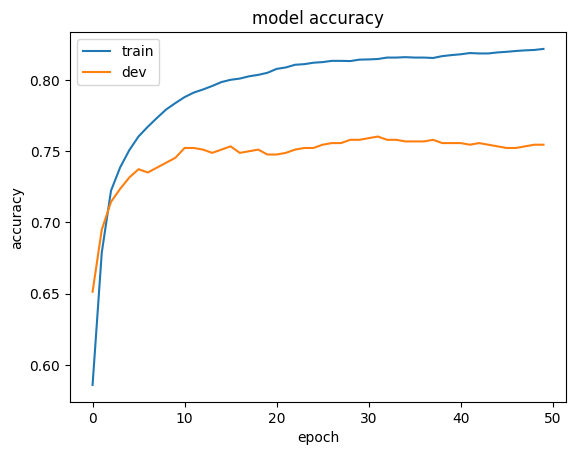

In [15]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

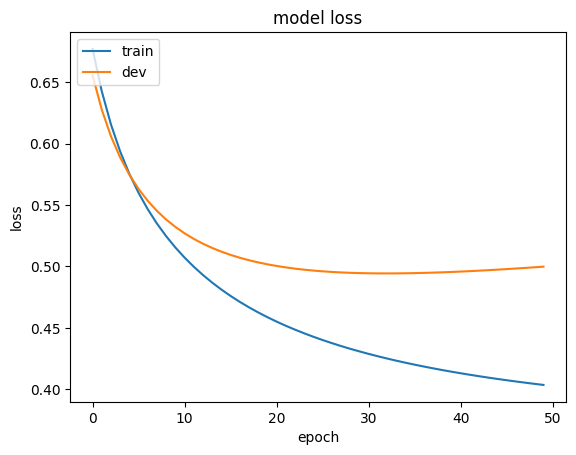

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

## 6. Evaluating the model

Once we fit the model we can use the method ```model.evaluate()``` to obtain the accuracy on test set.

In [17]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: ", score[1])

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7483 - loss: 0.4949
Accuracy:  0.7594727873802185


## 7. Model Tuning

### 7.1. Effect of Learning Rate

#### Exercise 2
In this session we'll focus on the importance of the learning rate. We'll compare a large and a small learning rate with the default one.


__Please run the following cells and answers to the next questions:__

- Why we obtain such a different plots with each learning rate?

- What is the difference when comparing the following curves:
   - ```train large``` vs  ```train orig```
   - ```dev large``` vs  ```dev orig```

- And the following ones:
   - ```train small``` vs  ```train orig```
   - ```dev small``` vs ```dev orig```




In [18]:
# Example of using optimizer object
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
tf.keras.utils.set_random_seed(2)

model2 = Sequential()

# add L2 weight regularization to logistic regression
regularizer = regularizers.l2(0.)
model2.add(Input(shape=(input_size,)))
model2.add(Dense(units=1, activation='sigmoid', kernel_regularizer=regularizer))

# Init Optimizer
lr_small = Adam(learning_rate=0.00001)
lr_large = Adam(learning_rate=0.5)

model2.compile(loss='binary_crossentropy', optimizer=lr_small, metrics=['accuracy'])
history_small_lr= model2.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_dev, y_dev), verbose=2)

model2.compile(loss='binary_crossentropy', optimizer=lr_large, metrics=['accuracy'])
history_large_lr= model2.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_dev, y_dev), verbose=2)


Epoch 1/50
217/217 - 1s - 5ms/step - accuracy: 0.5136 - loss: 0.6948 - val_accuracy: 0.5344 - val_loss: 0.6927
Epoch 2/50
217/217 - 0s - 2ms/step - accuracy: 0.5165 - loss: 0.6943 - val_accuracy: 0.5333 - val_loss: 0.6922
Epoch 3/50
217/217 - 0s - 2ms/step - accuracy: 0.5201 - loss: 0.6938 - val_accuracy: 0.5367 - val_loss: 0.6917
Epoch 4/50
217/217 - 0s - 2ms/step - accuracy: 0.5217 - loss: 0.6933 - val_accuracy: 0.5378 - val_loss: 0.6913
Epoch 5/50
217/217 - 0s - 1ms/step - accuracy: 0.5237 - loss: 0.6929 - val_accuracy: 0.5378 - val_loss: 0.6908
Epoch 6/50
217/217 - 0s - 1ms/step - accuracy: 0.5254 - loss: 0.6924 - val_accuracy: 0.5401 - val_loss: 0.6903
Epoch 7/50
217/217 - 0s - 2ms/step - accuracy: 0.5267 - loss: 0.6919 - val_accuracy: 0.5390 - val_loss: 0.6899
Epoch 8/50
217/217 - 0s - 1ms/step - accuracy: 0.5302 - loss: 0.6914 - val_accuracy: 0.5424 - val_loss: 0.6894
Epoch 9/50
217/217 - 0s - 1ms/step - accuracy: 0.5324 - loss: 0.6910 - val_accuracy: 0.5436 - val_loss: 0.6890
E

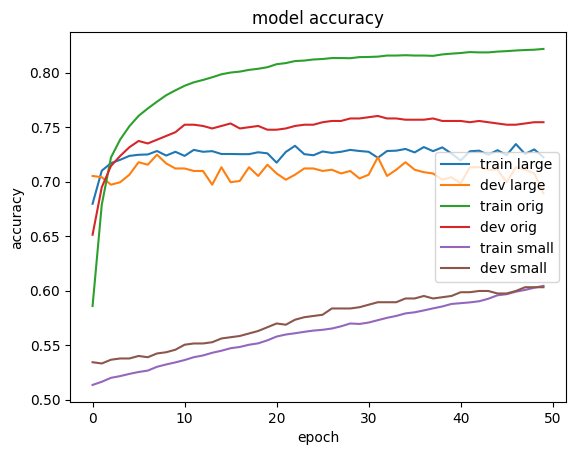

In [19]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history_large_lr.history['accuracy'])
plt.plot(history_large_lr.history['val_accuracy'])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.plot(history_small_lr.history['accuracy'])
plt.plot(history_small_lr.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train large', 'dev large', 'train orig', 'dev orig', 'train small', 'dev small'], loc='center right')
plt.show()

The learning rate has a direct impact on the model estimation. If see the small learning rate and train for a fixed epochs (let say, 50) the model will has a huge bias:
- The model is far from memorizing the training set, and the difference of the accuracy between training and development is minimum.

If the model is using a large learning rate, the model will overfit very fast:
- The model stacks on a plateau very fast. It looks like the model ended up in local minima.


### 7.2. Improving The Baseline Model

#### Exercise 3

The model in previus section uses learning reate values that might not be optimum ones. It would be great if you could try improving the model by exploring different hyperparameters. For example,  you can explore the following ones:
- Learning rates of the optimizer.
- Number of epochs.
- Vocabulary size (using larger set of words).


In [20]:
# process the data so we get vocabulary size using the whole training set
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils
tf.keras.utils.set_random_seed(2)

# Leave empty to create a tokenize that takes the whole set of words as vocab
# We take the 10000 most frequent words
tokenizer = text.Tokenizer(num_words=10000)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts) # Create word index using only training part

# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts, mode='binary')
x_dev = tokenizer.texts_to_matrix(dev_texts, mode='binary')
x_test = tokenizer.texts_to_matrix(test_texts, mode='binary')

# Converts the labels to a one-hot representation
y_train = train_labels
y_dev = dev_labels
y_test = test_labels

print('Text of the first examples: \n{}\n'.format(train_texts.iloc[0]))
print('Vector of the first example:\n{}\n'.format(x_train[0]))
print('Binary representation of the output:\n{}\n'.format(y_train[0]))

print('Shape of the training set (nb_examples, vector_size): {}\n'.format(x_train.shape))

Text of the first examples: 
This rush to profits has created a predictably efficient piece of business notable largely for its overwhelming creepiness , for an eagerness to create images you wish you had n't seen , which , in this day and age , is of course the point .

Vector of the first example:
[0. 1. 1. ... 0. 0. 0.]

Binary representation of the output:
1

Shape of the training set (nb_examples, vector_size): (6920, 10000)



In [21]:
from tensorflow.keras import Sequential, Input, regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def get_model(input_size):
    model = Sequential()
    # add L2 weight regularization to logistic regression
    regularizer = regularizers.l2(0.)
    model.add(Input(shape=(input_size,)))
    model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=regularizer))
    return model

In [22]:
tf.keras.utils.set_random_seed(2)
lrs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5]
number_epochs = 50
batch_size = 32
input_size = x_train.shape[1]

history = {}
for lr in lrs:
    model = get_model(input_size)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    history[lr] = model.fit(x_train, y_train, epochs=number_epochs,
                            batch_size=batch_size,
                            validation_data=(x_dev, y_dev), verbose=2)

Epoch 1/50
217/217 - 3s - 12ms/step - accuracy: 0.5072 - loss: 0.6931 - val_accuracy: 0.5241 - val_loss: 0.6929
Epoch 2/50
217/217 - 1s - 5ms/step - accuracy: 0.5171 - loss: 0.6924 - val_accuracy: 0.5333 - val_loss: 0.6923
Epoch 3/50
217/217 - 1s - 3ms/step - accuracy: 0.5283 - loss: 0.6917 - val_accuracy: 0.5424 - val_loss: 0.6917
Epoch 4/50
217/217 - 1s - 4ms/step - accuracy: 0.5360 - loss: 0.6909 - val_accuracy: 0.5470 - val_loss: 0.6911
Epoch 5/50
217/217 - 1s - 4ms/step - accuracy: 0.5451 - loss: 0.6902 - val_accuracy: 0.5505 - val_loss: 0.6906
Epoch 6/50
217/217 - 0s - 2ms/step - accuracy: 0.5553 - loss: 0.6895 - val_accuracy: 0.5470 - val_loss: 0.6900
Epoch 7/50
217/217 - 0s - 2ms/step - accuracy: 0.5656 - loss: 0.6887 - val_accuracy: 0.5482 - val_loss: 0.6894
Epoch 8/50
217/217 - 0s - 2ms/step - accuracy: 0.5756 - loss: 0.6880 - val_accuracy: 0.5539 - val_loss: 0.6889
Epoch 9/50
217/217 - 0s - 2ms/step - accuracy: 0.5847 - loss: 0.6873 - val_accuracy: 0.5642 - val_loss: 0.6883


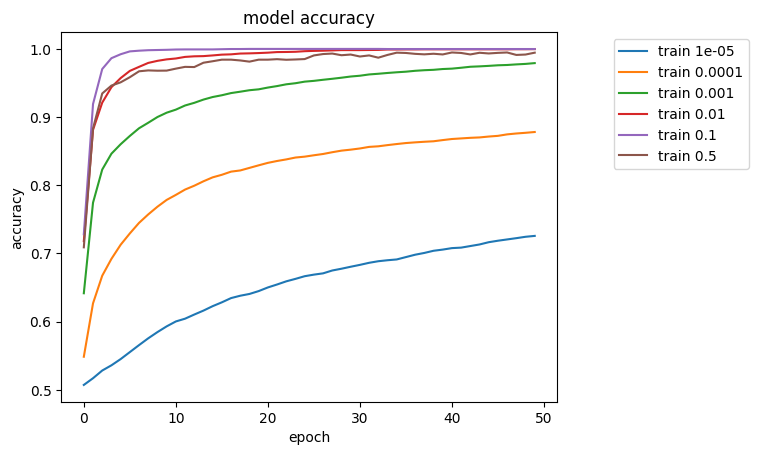

In [23]:
import matplotlib.pyplot as plt

# summarize history for accuracy
legend=[]
for lr in lrs:
    plt.plot(history[lr].history['accuracy'])
    #plt.plot(history[lr].history['val_accuracy'])
    legend.append('train {}'.format(lr))
    #legend.append('dev {}'.format(lr))

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(legend, bbox_to_anchor=(1.4, 1), loc='upper right')
plt.show()

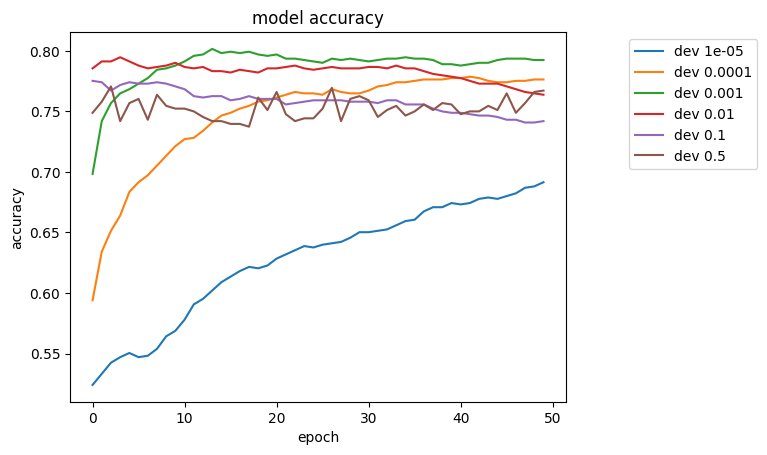

In [24]:
import matplotlib.pyplot as plt

# summarize history for accuracy
legend=[]
for lr in lrs:
    #plt.plot(history[lr].history['accuracy'])
    plt.plot(history[lr].history['val_accuracy'])
    #legend.append('train {}'.format(lr))
    legend.append('dev {}'.format(lr))

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(legend, bbox_to_anchor=(1.4, 1), loc='upper right')
plt.show()

In [25]:
best_epochs = []
accs = []
for lr in lrs:
    index = np.argmax(history[lr].history['val_accuracy'])
    best_epochs.append(index+1)
    accs.append(history[lr].history['val_accuracy'][index])
pd.DataFrame(data={'lr': lrs, 'best_epoch':best_epochs, 'acc':accs})

,lr,best_epoch,acc
0,0.00001,50,0.691514
1,0.00010,42,0.778670
2,0.00100,14,0.801606
3,0.01000,4,0.794725
4,0.10000,1,0.775229
5,0.50000,3,0.770642
